In [6]:
import os
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import show, show_hist
from matplotlib.gridspec import GridSpec
from dataset import BuildingDataset
IMG_PATH = '/shared/marangi/projects/EVOCITY/building_extraction/data/AerialImageDataset/train/images'
LABELS_PATH = '/shared/marangi/projects/EVOCITY/building_extraction/data/AerialImageDataset/train/gt'
images = os.listdir(IMG_PATH)
labels = os.listdir(LABELS_PATH)

In [12]:
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader
transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True), # Converte a float32 E divide per 255
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizza le immagini con mu e sigma di ImageNet (utile per transfer learning)
        ])
dataset = BuildingDataset(img_path=IMG_PATH, labels_path=LABELS_PATH, transform=None)
dl = DataLoader(
    dataset = dataset,
    batch_size = 1,
    shuffle = True
)

In [13]:
item = next(iter(dl))
item

[tensor([[[[101, 101,  95,  ..., 111, 124, 163],
           [101,  95,  90,  ..., 113, 158, 179],
           [ 95,  87,  89,  ..., 120, 163, 171],
           ...,
           [ 66,  60,  21,  ...,  92,  89,  79],
           [ 70,  51,  29,  ...,  81,  74,  80],
           [ 65,  53,  41,  ...,  82,  71,  85]],
 
          [[116, 113, 108,  ..., 107, 120, 163],
           [110, 103, 101,  ..., 108, 161, 181],
           [107,  98, 101,  ..., 115, 163, 167],
           ...,
           [ 94,  87,  41,  ..., 121, 119, 100],
           [ 97,  74,  45,  ..., 101,  96, 104],
           [ 91,  79,  63,  ..., 107,  92, 107]],
 
          [[ 82,  81,  79,  ...,  82, 100, 146],
           [ 80,  72,  73,  ...,  88, 145, 172],
           [ 75,  68,  71,  ...,  96, 150, 156],
           ...,
           [ 78,  69,  22,  ...,  70,  72,  53],
           [ 82,  56,  25,  ...,  57,  52,  62],
           [ 75,  60,  42,  ...,  63,  47,  66]]]], dtype=torch.uint8),
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]

In [19]:
immagine = item[0][0]

<Axes: title={'center': 'Mask: austin21.tif'}>

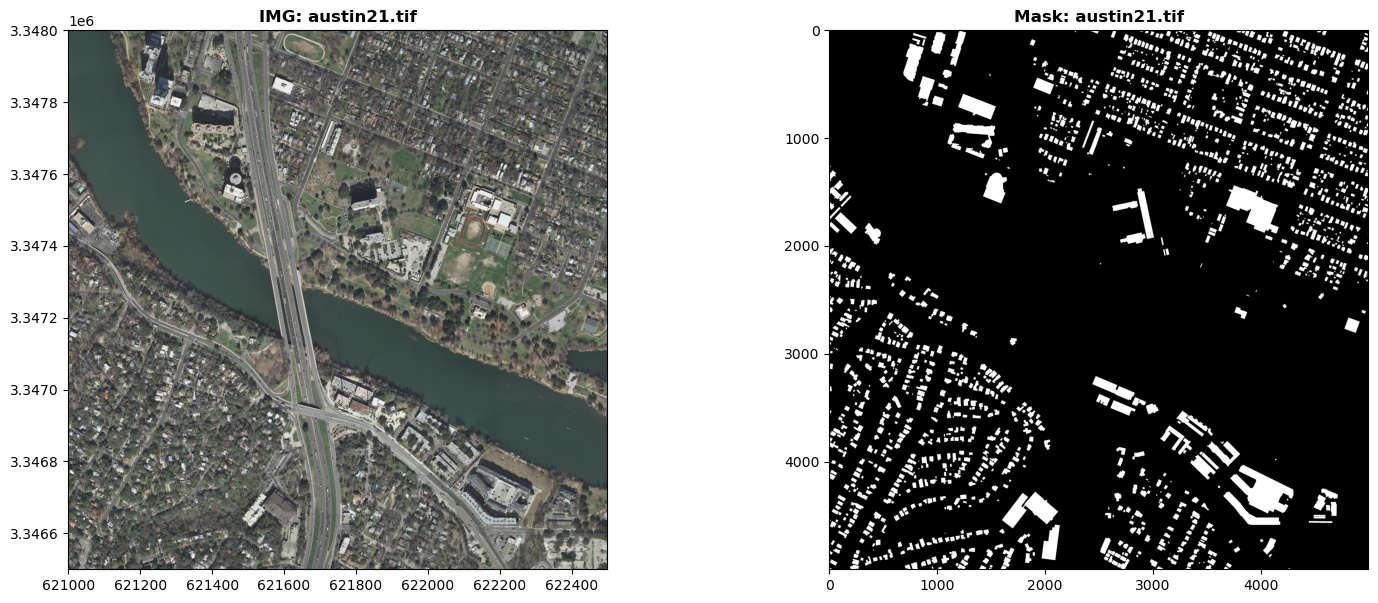

In [10]:
idx = 113
img = rio.open(os.path.join(IMG_PATH, images[idx]))
gt = rio.open(os.path.join(LABELS_PATH, labels[idx]))
band1, band2, band3 = img.read()
mask = gt.read()
fig, (rgb_ax, mask_ax) = plt.subplots(1, 2, figsize=(18, 7))
show(img, ax = rgb_ax, title=f'IMG: {images[idx]}')
show(mask, ax=mask_ax, cmap='binary_r', title=f'Mask: {labels[idx]}')

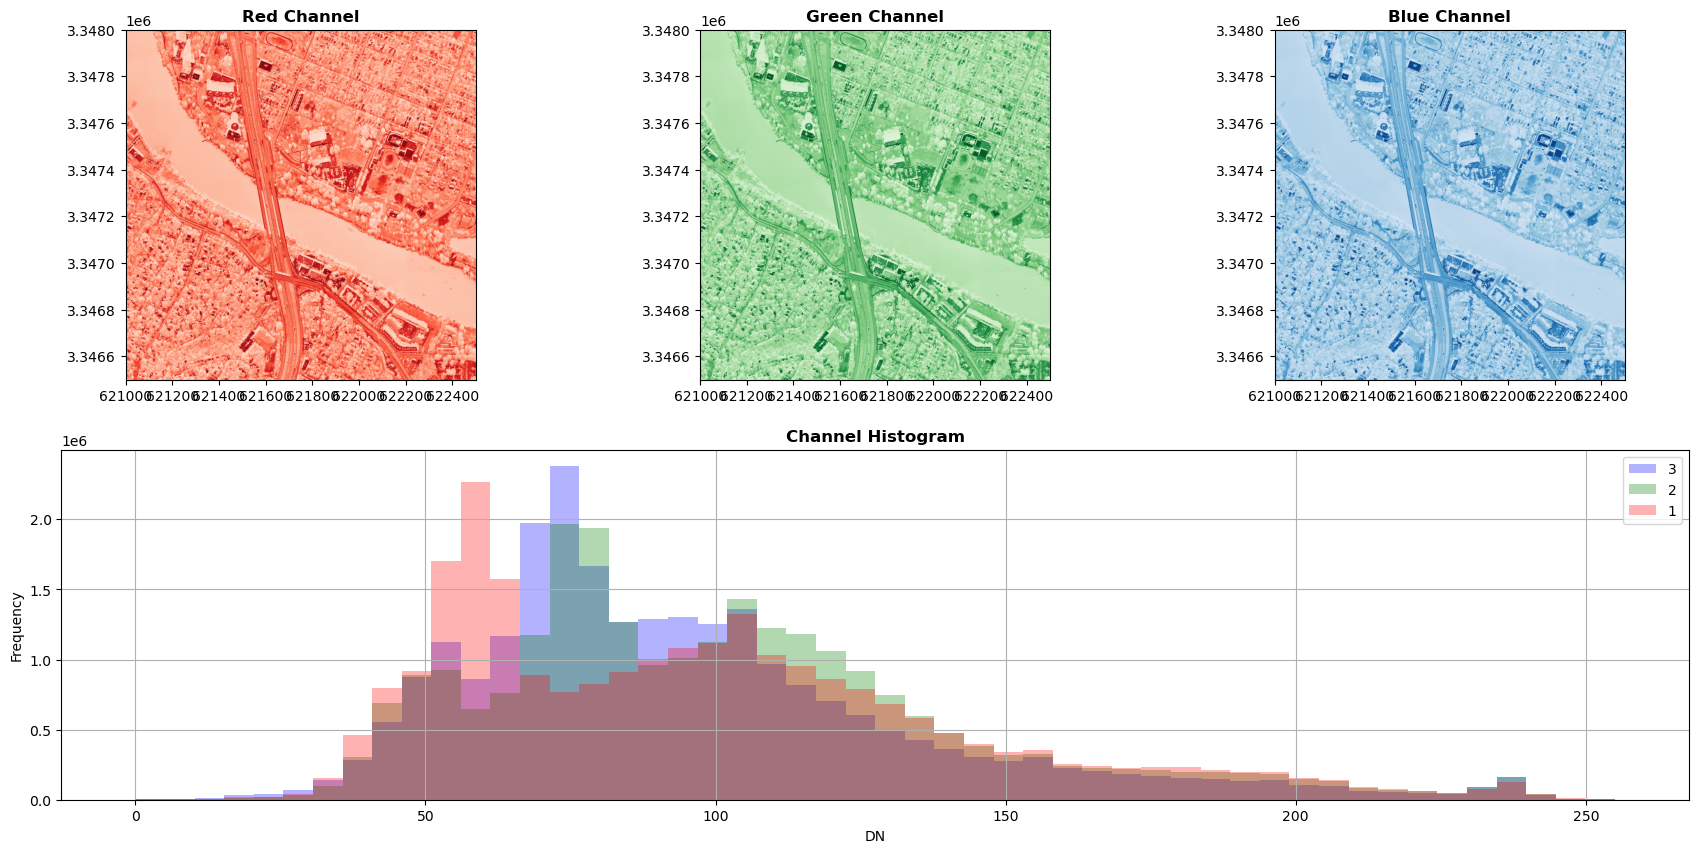

In [11]:
fig = plt.figure(figsize=(21,10))
gs = GridSpec(nrows=2, ncols=3, figure=fig)

axr = fig.add_subplot(gs[0,0])
axg = fig.add_subplot(gs[0,1])
axb = fig.add_subplot(gs[0,2])
axhist = fig.add_subplot(gs[1, :])

show((img, 1), ax=axr, cmap='Reds', title='Red Channel')
show((img, 2), ax=axg, cmap='Greens', title='Green Channel')
show((img, 3), ax=axb, cmap='Blues', title='Blue Channel')
show_hist(source=img, bins=50, title='Channel Histogram', histtype='stepfilled', alpha=0.3, ax=axhist)


In [45]:
import torch
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
import numpy as np

model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
processor = SegformerImageProcessor.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512', do_normalize=True)

/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [47]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_flash_attn_3',
 '_check_and_enable_flex_attn',
 '_check_and_enable_sdpa',
 '_checkpoint_conversion_mapping',
 '_compiled_call_impl',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_device_mesh',
 '_dispatch_accelerate_model',
 '_fix_state_dict_key_on_l

In [46]:
imm_preproc = processor(images=immagine, return_tensors="pt")
imm_preproc

{'pixel_values': tensor([[[[-0.7479, -0.9534, -0.2342,  ...,  0.0569,  0.0569,  0.1768],
          [-0.9534, -0.9705, -0.0287,  ...,  0.4166,  0.6392,  0.6563],
          [-0.6965, -0.5424,  0.1426,  ...,  0.6221,  0.7248,  0.6906],
          ...,
          [-1.0562, -1.5699, -1.2617,  ..., -1.2617, -1.0904, -1.0219],
          [-0.9192, -1.2788, -1.4500,  ..., -0.9020, -0.6109, -0.5253],
          [-1.2617, -1.1932, -1.8439,  ..., -0.5596, -0.5424, -0.6109]],

         [[-0.3901, -0.6527, -0.1275,  ...,  0.0126,  0.0826,  0.2227],
          [-0.6527, -0.7227, -0.0049,  ...,  0.4328,  0.6429,  0.6954],
          [-0.3901, -0.3725,  0.1877,  ...,  0.6429,  0.7654,  0.7479],
          ...,
          [-0.5126, -1.1078, -0.9678,  ..., -0.8277, -0.6527, -0.6877],
          [-0.3550, -0.7052, -1.0203,  ..., -0.5126, -0.2150, -0.2150],
          [-0.7402, -0.6527, -1.4055,  ..., -0.4601, -0.4601, -0.2325]],

         [[-0.6890, -0.8110, -0.1661,  ..., -0.1661, -0.1312,  0.0431],
          [-0

In [28]:
im2 = imm_preproc['pixel_values'][0]

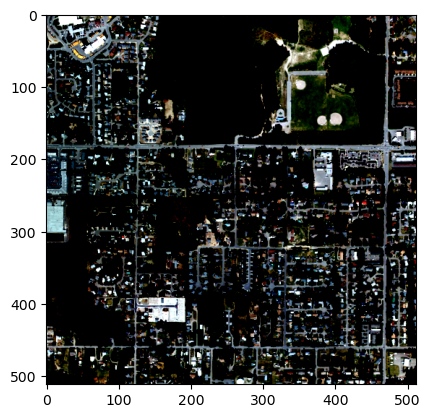

In [37]:
#im2 = im2.numpy()
im2 = im2.transpose((1, 2, 0))
im2 = np.clip(im2, 0, 1)
plt.imshow(im2)

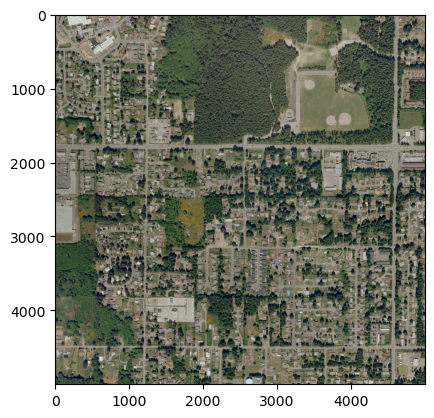

In [33]:
immmmm = immagine.numpy()
immmmm = immmmm.transpose((1, 2, 0))
plt.imshow(immmmm)

In [40]:
im2

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.05693974, 0.01260505, 0.        ],
        [0.05693974, 0.08263306, 0.        ],
        [0.17681314, 0.2226892 , 0.04305018]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.04305018],
        ...,
        [0.41655967, 0.4327732 , 0.33934647],
        [0.63918144, 0.64285725, 0.5833553 ],
        [0.6563062 , 0.69537824, 0.65307206]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.14256364, 0.18767506, 0.2522005 ],
        ...,
        [0.6220567 , 0.64285725, 0.6356429 ],
        [0.72480524, 0.76540625, 0.7576472 ],
        [0.69055575, 0.74789923, 0.7227889 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0